開始生成 Drink Dataset 並比較名目型屬性處理方法...

飲品相似度編碼設計說明
我們根據以下5個維度定義飲品特徵向量：
1. 碳酸飲料特性 (0-1)
2. 咖啡特性 (0-1)
3. 甜度 (0-1)
4. 咖啡因含量 (0-1)
5. 奶類含量 (0-1)

Coke        : [1, 0, 0.8, 0.6, 0]
Pepsi       : [1, 0, 0.8, 0.6, 0]
Sprite      : [1, 0, 0.7, 0, 0]
7Up         : [1, 0, 0.7, 0, 0]
Cappuccino  : [0, 1, 0.3, 0.9, 0.8]
Espresso    : [0, 1, 0.1, 1.0, 0]
Latte       : [0, 1, 0.4, 0.7, 0.9]
Mocha       : [0, 1, 0.6, 0.8, 0.7]

相似度計算使用餘弦相似度，範圍為[0,1]
相似度越高，表示兩種飲品的特性越接近

1-of-k編碼後特徵維度: (1600, 11)
相似度編碼後特徵維度: (1600, 11)

應用 t-SNE 到兩種編碼方法...
繪製比較結果...


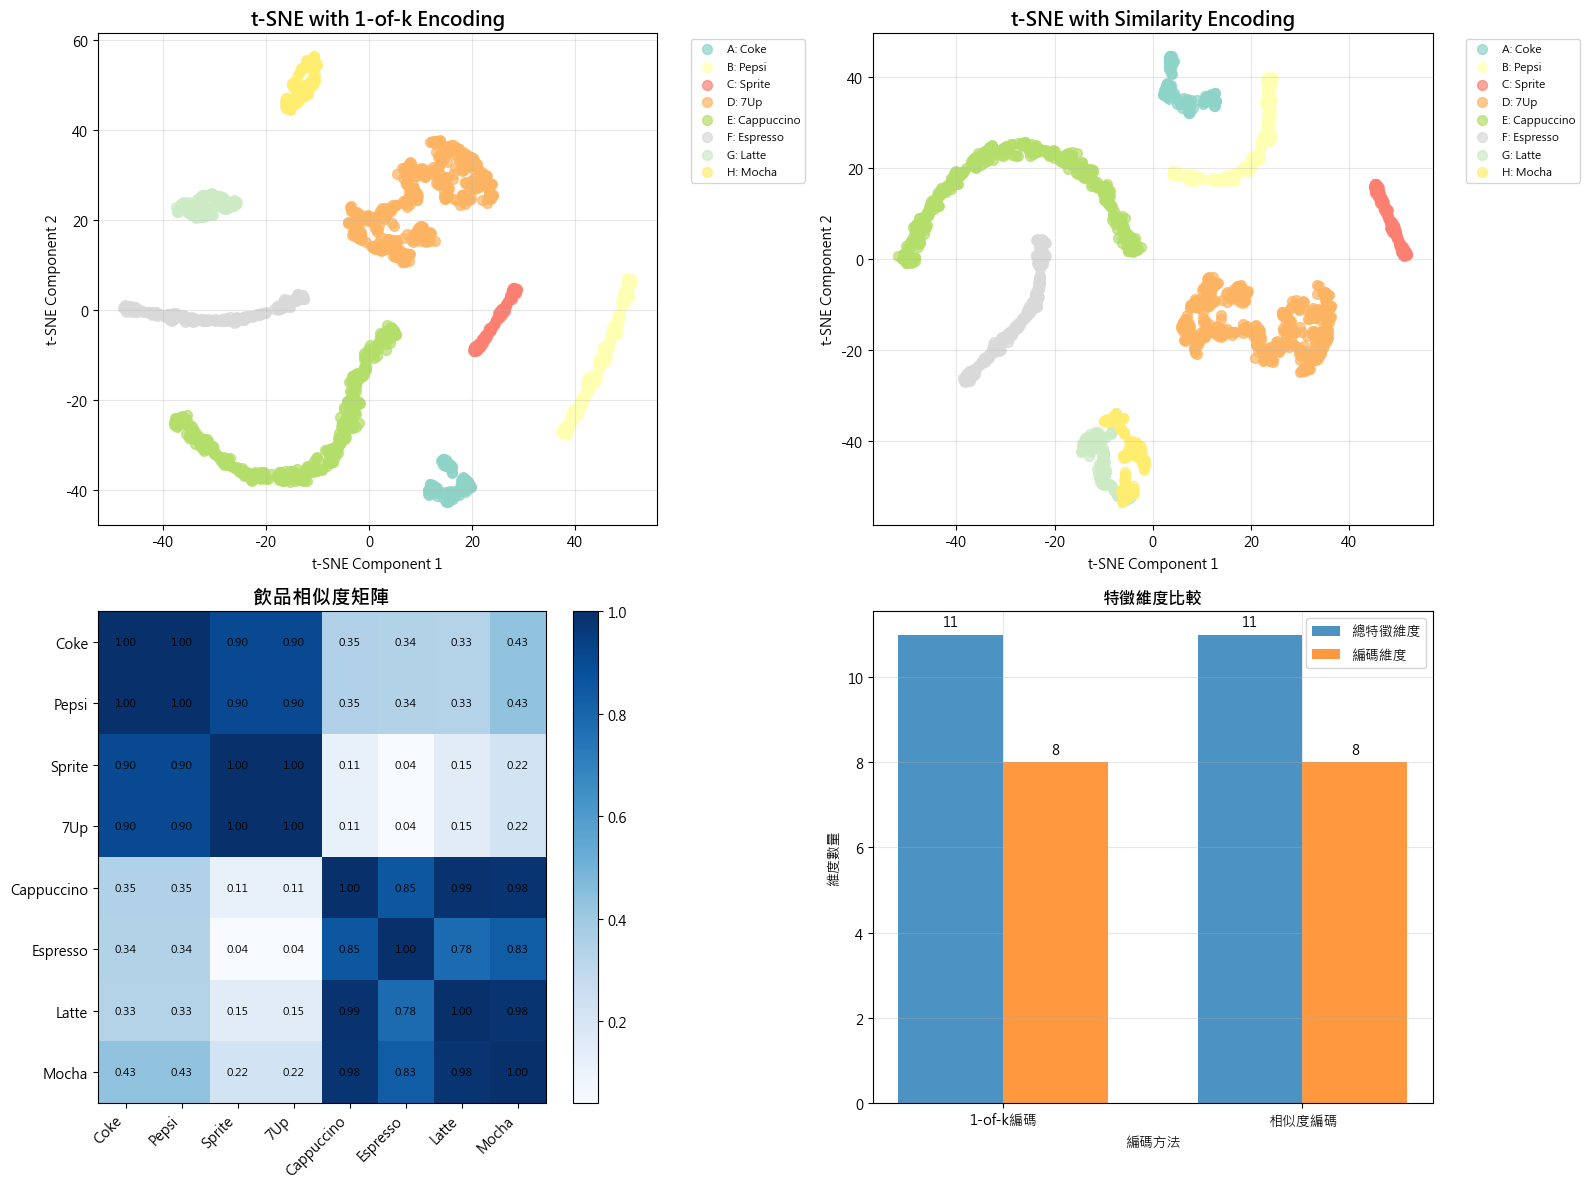


聚類品質分析
1-of-k編碼 Silhouette Score: 0.5317
相似度編碼 Silhouette Score: 0.4488
1-of-k編碼 Adjusted Rand Index: 0.8286
相似度編碼 Adjusted Rand Index: 0.6217

比較不同 perplexity 參數的影響...


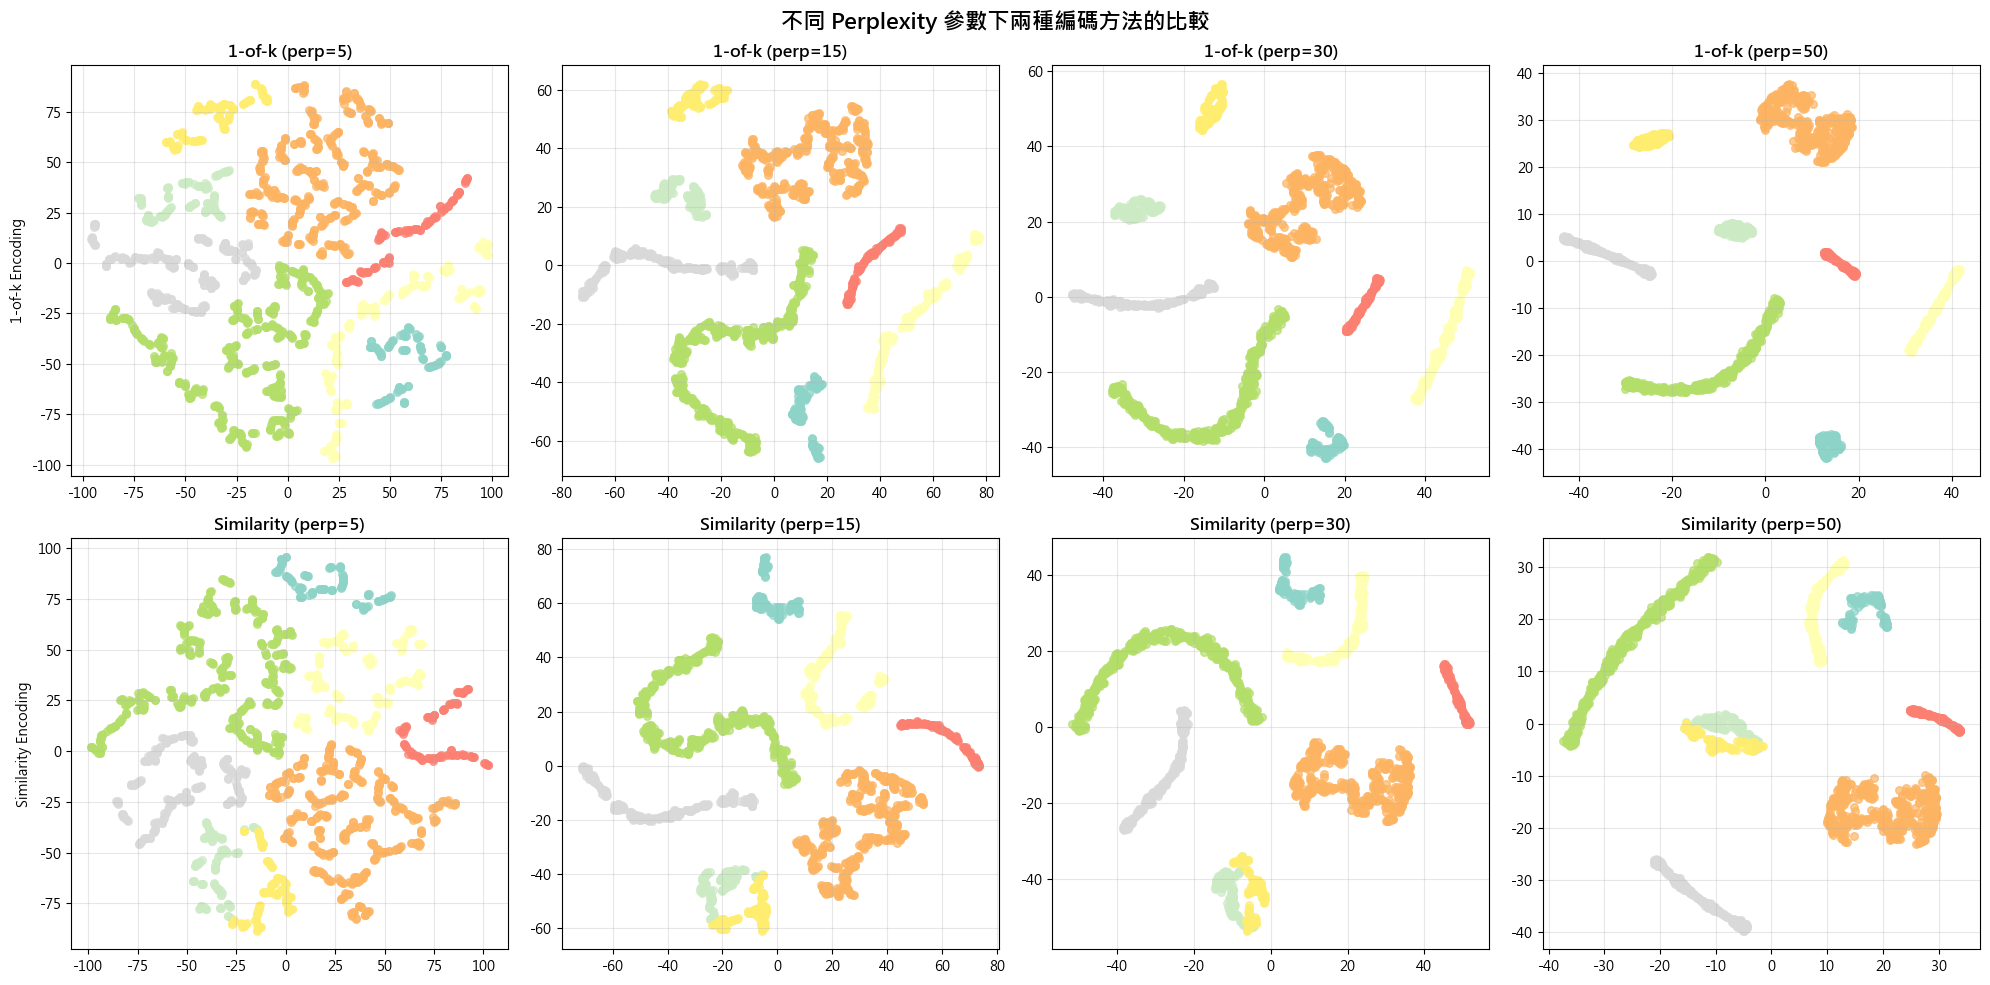


結論與建議
1-of-k編碼:
- 優點: 不假設類別間關係，適合完全獨立的名目變數
- 缺點: 高維度，可能導致維度詛咒，忽略潛在語義關係

相似度編碼:
- 優點: 保留語義資訊，降低維度，更符合人類認知
- 缺點: 需要領域知識定義相似度，可能引入主觀偏見

在此資料集上，相似度編碼的聚類效果:
- 1-of-k編碼表現較好，可能因為類別間差異已足夠明顯


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

def generate_drink_dataset():
    """
    根據表格資訊生成Drink Dataset
    """
    # 定義資料集參數
    drink_info = {
        'A': {'Drink': 'Coke', 'Rank': 8, 'Amount': (100, 200), 'Quantity': (500, 1000), 'Count': 100},
        'B': {'Drink': 'Pepsi', 'Rank': 7, 'Amount': (200, 10), 'Quantity': (500, 1000), 'Count': 200},
        'C': {'Drink': 'Sprite', 'Rank': 6, 'Amount': (200, 10), 'Quantity': (500, 1000), 'Count': 100},
        'D': {'Drink': '7Up', 'Rank': 5, 'Amount': (400, 100), 'Quantity': (500, 1000), 'Count': 400},
        'E': {'Drink': 'Cappuccino', 'Rank': 4, 'Amount': (700, 10), 'Quantity': (1, 500), 'Count': 400},
        'F': {'Drink': 'Espresso', 'Rank': 3, 'Amount': (700, 10), 'Quantity': (1, 500), 'Count': 200},
        'G': {'Drink': 'Latte', 'Rank': 2, 'Amount': (800, 300), 'Quantity': (1, 500), 'Count': 100},
        'H': {'Drink': 'Mocha', 'Rank': 1, 'Amount': (900, 400), 'Quantity': (1, 500), 'Count': 100}
    }
    
    all_data = []
    
    for class_label, info in drink_info.items():
        # 生成每個類別的資料
        count = info['Count']
        
        # Amount: 常態分配 N(μ, σ)
        amount_mean, amount_std = info['Amount']
        amounts = np.random.normal(amount_mean, amount_std, count)
        amounts = np.maximum(amounts, 0)  # 確保非負值
        
        # Quantity: 均勻分配
        qty_min, qty_max = info['Quantity']
        quantities = np.random.uniform(qty_min, qty_max, count)
        
        # 創建該類別的資料
        for i in range(count):
            all_data.append({
                'Class': class_label,
                'Drink': info['Drink'],
                'Rank': info['Rank'],
                'Amount': amounts[i],
                'Quantity': quantities[i]
            })
    
    return pd.DataFrame(all_data)

def create_drink_similarity_matrix():
    """
    創建飲品相似度矩陣
    基於飲品類型的語義相似度
    """
    drinks = ['Coke', 'Pepsi', 'Sprite', '7Up', 'Cappuccino', 'Espresso', 'Latte', 'Mocha']
    
    # 定義飲品特徵向量 (碳酸飲料特性, 咖啡特性, 甜度, 咖啡因含量, 奶類含量)
    drink_features = {
        'Coke': [1, 0, 0.8, 0.6, 0],        # 碳酸可樂
        'Pepsi': [1, 0, 0.8, 0.6, 0],       # 碳酸可樂
        'Sprite': [1, 0, 0.7, 0, 0],        # 碳酸汽水
        '7Up': [1, 0, 0.7, 0, 0],           # 碳酸汽水
        'Cappuccino': [0, 1, 0.3, 0.9, 0.8], # 咖啡+奶
        'Espresso': [0, 1, 0.1, 1.0, 0],    # 純咖啡
        'Latte': [0, 1, 0.4, 0.7, 0.9],     # 咖啡+大量奶
        'Mocha': [0, 1, 0.6, 0.8, 0.7]      # 咖啡+奶+巧克力
    }
    
    # 計算相似度矩陣
    feature_matrix = np.array([drink_features[drink] for drink in drinks])
    similarity_matrix = cosine_similarity(feature_matrix)
    
    return drinks, similarity_matrix

def encode_categorical_similarity(df, similarity_matrix, drinks):
    """
    使用相似度編碼名目型屬性
    """
    drink_to_idx = {drink: idx for idx, drink in enumerate(drinks)}
    
    # 為每個飲品創建相似度向量
    similarity_encoded = []
    for drink in df['Drink']:
        idx = drink_to_idx[drink]
        similarity_vector = similarity_matrix[idx]
        similarity_encoded.append(similarity_vector)
    
    similarity_encoded = np.array(similarity_encoded)
    
    # 合併數值特徵
    numerical_features = df[['Rank', 'Amount', 'Quantity']].values
    X_similarity = np.hstack([similarity_encoded, numerical_features])
    
    return X_similarity

def preprocess_data_methods(df):
    """
    使用兩種方法處理名目型屬性
    """
    drinks, similarity_matrix = create_drink_similarity_matrix()
    
    # 方法1: 1-of-k編碼 (One-Hot Encoding)
    drink_onehot = pd.get_dummies(df['Drink'], prefix='Drink')
    X_onehot = pd.concat([drink_onehot, df[['Rank', 'Amount', 'Quantity']]], axis=1).values
    
    # 方法2: 相似度編碼
    X_similarity = encode_categorical_similarity(df, similarity_matrix, drinks)
    
    y = df['Class'].values
    
    return X_onehot, X_similarity, y, drinks, similarity_matrix

def apply_tsne_comparison(X_onehot, X_similarity, y, perplexity=30):
    """
    對兩種編碼方法分別應用t-SNE
    """
    # 標準化資料
    scaler1 = StandardScaler()
    X_onehot_scaled = scaler1.fit_transform(X_onehot)
    
    scaler2 = StandardScaler()
    X_similarity_scaled = scaler2.fit_transform(X_similarity)
    
    # 應用t-SNE
    tsne1 = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, random_state=42)
    X_tsne_onehot = tsne1.fit_transform(X_onehot_scaled)
    
    tsne2 = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, random_state=42)
    X_tsne_similarity = tsne2.fit_transform(X_similarity_scaled)
    
    return X_tsne_onehot, X_tsne_similarity

def plot_encoding_comparison(X_tsne_onehot, X_tsne_similarity, y, df, similarity_matrix, drinks):
    """
    比較兩種編碼方法的t-SNE結果
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 顏色對應
    colors = plt.cm.Set3(np.linspace(0, 1, len(df['Class'].unique())))
    class_colors = dict(zip(sorted(df['Class'].unique()), colors))
    
    # 1-of-k編碼結果
    ax1 = axes[0, 0]
    for class_label in sorted(df['Class'].unique()):
        mask = y == class_label
        drink_name = df[df['Class'] == class_label]['Drink'].iloc[0]
        ax1.scatter(X_tsne_onehot[mask, 0], X_tsne_onehot[mask, 1], 
                   c=[class_colors[class_label]], 
                   label=f'{class_label}: {drink_name}', 
                   alpha=0.7, s=50)
    ax1.set_title('t-SNE with 1-of-k Encoding', fontsize=14, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 相似度編碼結果
    ax2 = axes[0, 1]
    for class_label in sorted(df['Class'].unique()):
        mask = y == class_label
        drink_name = df[df['Class'] == class_label]['Drink'].iloc[0]
        ax2.scatter(X_tsne_similarity[mask, 0], X_tsne_similarity[mask, 1], 
                   c=[class_colors[class_label]], 
                   label=f'{class_label}: {drink_name}', 
                   alpha=0.7, s=50)
    ax2.set_title('t-SNE with Similarity Encoding', fontsize=14, fontweight='bold')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # 飲品相似度熱圖
    ax3 = axes[1, 0]
    im = ax3.imshow(similarity_matrix, cmap='Blues', aspect='auto')
    ax3.set_xticks(range(len(drinks)))
    ax3.set_yticks(range(len(drinks)))
    ax3.set_xticklabels(drinks, rotation=45, ha='right')
    ax3.set_yticklabels(drinks)
    ax3.set_title('飲品相似度矩陣', fontsize=14, fontweight='bold')
    
    # 添加數值標註
    for i in range(len(drinks)):
        for j in range(len(drinks)):
            text = ax3.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=ax3)
    
    # 特徵維度比較
    ax4 = axes[1, 1]
    methods = ['1-of-k編碼', '相似度編碼']
    dimensions = [len(drinks) + 3, len(drinks) + 3]  # 飲品維度 + 3個數值特徵
    encoding_dims = [len(drinks), len(drinks)]  # 編碼維度
    
    x = np.arange(len(methods))
    width = 0.35
    
    ax4.bar(x - width/2, dimensions, width, label='總特徵維度', alpha=0.8)
    ax4.bar(x + width/2, encoding_dims, width, label='編碼維度', alpha=0.8)
    
    ax4.set_xlabel('編碼方法')
    ax4.set_ylabel('維度數量')
    ax4.set_title('特徵維度比較', fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(methods)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 添加數值標註
    for i, (total, encoding) in enumerate(zip(dimensions, encoding_dims)):
        ax4.text(i - width/2, total + 0.1, str(total), ha='center', va='bottom')
        ax4.text(i + width/2, encoding + 0.1, str(encoding), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def analyze_clustering_quality(X_tsne_onehot, X_tsne_similarity, y):
    """
    分析聚類品質
    """
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans
    
    print("\n" + "=" * 60)
    print("聚類品質分析")
    print("=" * 60)
    
    # 計算Silhouette Score
    sil_onehot = silhouette_score(X_tsne_onehot, y)
    sil_similarity = silhouette_score(X_tsne_similarity, y)
    
    print(f"1-of-k編碼 Silhouette Score: {sil_onehot:.4f}")
    print(f"相似度編碼 Silhouette Score: {sil_similarity:.4f}")
    
    # 使用K-means評估聚類效果
    kmeans_onehot = KMeans(n_clusters=8, random_state=42, n_init=10)
    kmeans_similarity = KMeans(n_clusters=8, random_state=42, n_init=10)
    
    pred_onehot = kmeans_onehot.fit_predict(X_tsne_onehot)
    pred_similarity = kmeans_similarity.fit_predict(X_tsne_similarity)
    
    from sklearn.metrics import adjusted_rand_score
    ari_onehot = adjusted_rand_score(y, pred_onehot)
    ari_similarity = adjusted_rand_score(y, pred_similarity)
    
    print(f"1-of-k編碼 Adjusted Rand Index: {ari_onehot:.4f}")
    print(f"相似度編碼 Adjusted Rand Index: {ari_similarity:.4f}")
    
    return sil_onehot, sil_similarity, ari_onehot, ari_similarity

def compare_perplexity_effects(X_onehot, X_similarity, y, df):
    """
    比較不同perplexity參數對兩種編碼方法的影響
    """
    perplexities = [5, 15, 30, 50]
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(df['Class'].unique())))
    class_colors = dict(zip(sorted(df['Class'].unique()), colors))
    
    # 標準化資料
    scaler1 = StandardScaler()
    X_onehot_scaled = scaler1.fit_transform(X_onehot)
    
    scaler2 = StandardScaler()
    X_similarity_scaled = scaler2.fit_transform(X_similarity)
    
    for i, perp in enumerate(perplexities):
        # 1-of-k編碼
        tsne1 = TSNE(n_components=2, perplexity=perp, n_iter=1000, random_state=42)
        X_tsne_onehot = tsne1.fit_transform(X_onehot_scaled)
        
        ax1 = axes[0, i]
        for class_label in sorted(df['Class'].unique()):
            mask = y == class_label
            ax1.scatter(X_tsne_onehot[mask, 0], X_tsne_onehot[mask, 1], 
                       c=[class_colors[class_label]], 
                       label=f'Class {class_label}', 
                       alpha=0.7, s=30)
        ax1.set_title(f'1-of-k (perp={perp})', fontweight='bold')
        if i == 0:
            ax1.set_ylabel('1-of-k Encoding')
        ax1.grid(True, alpha=0.3)
        
        # 相似度編碼
        tsne2 = TSNE(n_components=2, perplexity=perp, n_iter=1000, random_state=42)
        X_tsne_similarity = tsne2.fit_transform(X_similarity_scaled)
        
        ax2 = axes[1, i]
        for class_label in sorted(df['Class'].unique()):
            mask = y == class_label
            ax2.scatter(X_tsne_similarity[mask, 0], X_tsne_similarity[mask, 1], 
                       c=[class_colors[class_label]], 
                       label=f'Class {class_label}', 
                       alpha=0.7, s=30)
        ax2.set_title(f'Similarity (perp={perp})', fontweight='bold')
        if i == 0:
            ax2.set_ylabel('Similarity Encoding')
        ax2.grid(True, alpha=0.3)
    
    # 添加總標題
    plt.suptitle('不同 Perplexity 參數下兩種編碼方法的比較', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def explain_drink_similarity():
    """
    解釋飲品相似度設計理念
    """
    print("\n" + "=" * 60)
    print("飲品相似度編碼設計說明")
    print("=" * 60)
    print("我們根據以下5個維度定義飲品特徵向量：")
    print("1. 碳酸飲料特性 (0-1)")
    print("2. 咖啡特性 (0-1)")
    print("3. 甜度 (0-1)")
    print("4. 咖啡因含量 (0-1)")
    print("5. 奶類含量 (0-1)")
    print()
    
    drink_features = {
        'Coke': [1, 0, 0.8, 0.6, 0],
        'Pepsi': [1, 0, 0.8, 0.6, 0],
        'Sprite': [1, 0, 0.7, 0, 0],
        '7Up': [1, 0, 0.7, 0, 0],
        'Cappuccino': [0, 1, 0.3, 0.9, 0.8],
        'Espresso': [0, 1, 0.1, 1.0, 0],
        'Latte': [0, 1, 0.4, 0.7, 0.9],
        'Mocha': [0, 1, 0.6, 0.8, 0.7]
    }
    
    for drink, features in drink_features.items():
        print(f"{drink:12}: {features}")
    
    print("\n相似度計算使用餘弦相似度，範圍為[0,1]")
    print("相似度越高，表示兩種飲品的特性越接近")

def main():
    print("開始生成 Drink Dataset 並比較名目型屬性處理方法...")
    
    # 1. 生成資料集
    df = generate_drink_dataset()
    
    # 2. 解釋相似度設計
    explain_drink_similarity()
    
    # 3. 使用兩種方法處理名目型屬性
    X_onehot, X_similarity, y, drinks, similarity_matrix = preprocess_data_methods(df)
    
    print(f"\n1-of-k編碼後特徵維度: {X_onehot.shape}")
    print(f"相似度編碼後特徵維度: {X_similarity.shape}")
    
    # 4. 應用t-SNE
    print("\n應用 t-SNE 到兩種編碼方法...")
    X_tsne_onehot, X_tsne_similarity = apply_tsne_comparison(X_onehot, X_similarity, y)
    
    # 5. 視覺化比較
    print("繪製比較結果...")
    plot_encoding_comparison(X_tsne_onehot, X_tsne_similarity, y, df, similarity_matrix, drinks)
    
    # 6. 分析聚類品質
    sil_scores = analyze_clustering_quality(X_tsne_onehot, X_tsne_similarity, y)
    
    # 7. 比較不同perplexity的影響
    print("\n比較不同 perplexity 參數的影響...")
    compare_perplexity_effects(X_onehot, X_similarity, y, df)
    
    # 8. 輸出結論
    print("\n" + "=" * 60)
    print("結論與建議")
    print("=" * 60)
    print("1-of-k編碼:")
    print("- 優點: 不假設類別間關係，適合完全獨立的名目變數")
    print("- 缺點: 高維度，可能導致維度詛咒，忽略潛在語義關係")
    print()
    print("相似度編碼:")
    print("- 優點: 保留語義資訊，降低維度，更符合人類認知")
    print("- 缺點: 需要領域知識定義相似度，可能引入主觀偏見")
    print()
    print(f"在此資料集上，相似度編碼的聚類效果:")
    if sil_scores[1] > sil_scores[0]:
        print("- 相似度編碼表現較好，說明考慮語義關係有助於t-SNE降維")
    else:
        print("- 1-of-k編碼表現較好，可能因為類別間差異已足夠明顯")
    
    return df, X_tsne_onehot, X_tsne_similarity

# 執行主程式
if __name__ == "__main__":
    df, X_tsne_onehot, X_tsne_similarity = main()